## ADVERSARIAL VARIATIONAL BAYES 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print ("TF VERSION IS %s." % (tf.__version__))

TF VERSION IS 1.0.1.


## TO MAKE CODE SHORTER

In [2]:
slim   = tf.contrib.slim
tf_ds  = tf.contrib.distributions
tf_st  = tf.contrib.bayesflow.stochastic_tensor
tf_gr  = tf.contrib.graph_editor.graph_replace
tf_rdg = tf.reset_default_graph
tf_ds_mnd  = tf_ds.MultivariateNormalDiag
tf_ds_bern = tf_ds.Bernoulli
tf_vs   = tf.variable_scope
tf_relu = tf.nn.relu
tf_sigm = tf.nn.sigmoid
tf_gr   = tf.contrib.graph_editor.graph_replace
tf_scel = tf.nn.sigmoid_cross_entropy_with_logits
slim_fc = slim.fully_connected

## CONFIGURATION

In [3]:
cfg = {
    'n_data'    : 512,
    'batch_size': 512,
    'input_dim' : 4, # DIM(X)
    'latent_dim': 2, # DIM(Z)
    'eps_dim'   : 4, # DIM(EPS)
    'n_class'   : 4, 
    'n_layer_disc' : 2,    
    'n_hidden_disc': 256, 
    'n_layer_gen'  : 2,
    'n_hidden_gen' : 256,
    'n_layer_inf'  : 2,
    'n_hidden_inf' : 256,
}
print cfg

{'eps_dim': 4, 'n_layer_inf': 2, 'n_data': 512, 'n_class': 4, 'batch_size': 512, 'n_layer_disc': 2, 'latent_dim': 2, 'n_hidden_gen': 256, 'n_layer_gen': 2, 'n_hidden_inf': 256, 'input_dim': 4, 'n_hidden_disc': 256}


## CREATE TOY DATASET

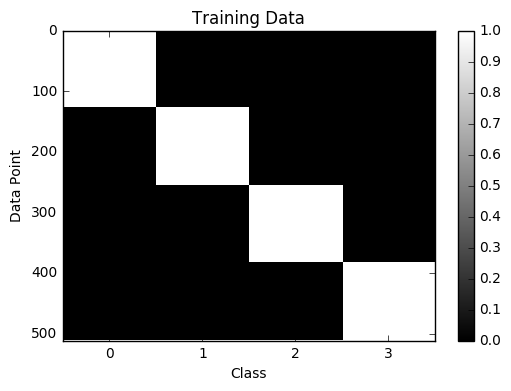

EACH ROW INDICATES A SINGLE DATA.


In [4]:
n_per_class = cfg['n_data'] / cfg['n_class']
labels  = np.concatenate([[i]*n_per_class for i in xrange(cfg['n_class'])])
np_data = np.eye(cfg['input_dim'], dtype=np.float32)[labels]
# PLOT
plt.imshow(np_data, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar()
plt.xticks(range(cfg['input_dim']))
plt.xlabel('Class')
plt.ylabel('Data Point')
plt.title('Training Data')
plt.show()
print ("EACH ROW INDICATES A SINGLE DATA.")

## NETWORK 

In [5]:
def standard_normal(_shape, **kwargs):
    # MULTIVARIATE NORMAL DIAG
    _mu = tf.zeros(_shape)
    _ds = tf.ones(_shape)
    _mnd = tf_ds_mnd(mu=_mu, diag_stdev=_ds, **kwargs)
    return tf_st.StochasticTensor(_mnd)

def generative_network(_batch_size, _latent_dim, _input_dim, _n_layer, _n_hidden, eps=1e-6):
    with tf_vs('GENERATIVE'):
        _z = standard_normal([_batch_size, _latent_dim], name='p_z')
        _h = slim.repeat(_z.value(), _n_layer, slim_fc, _n_hidden, activation_fn=tf_relu)
        _p = eps + (1 - 2*eps)*slim_fc(_h, _input_dim, activation_fn=tf_sigm)
        _x = tf_st.StochasticTensor(tf_ds_bern(p=_p, name="p_x"))
    return [_x, _z] # X: IMAGE / Z: RANDOM VECOTR

def generative_network2(_z_val, _input_dim, _n_layer, _n_hidden, eps=1e-6):
    with tf_vs('GENERATIVE') as scope:
        scope.reuse_variables()
        _h = slim.repeat(_z_val, _n_layer, slim_fc, _n_hidden, activation_fn=tf_relu)
        _p = eps + (1 - 2*eps)*slim_fc(_h, _input_dim, activation_fn=tf_sigm)
        _x = tf_st.StochasticTensor(tf_ds_bern(p=_p, name="p_x"))
    return _x

def inference_network(_x, _latent_dim, _n_layer, _n_hidden, _eps_dim):
    _eps = standard_normal([_x.get_shape().as_list()[0], _eps_dim], name='eps')
    _eps_val = _eps.value()
    _h = tf.concat([_x, _eps_val], 1)
    with tf_vs('INFERENCE'):
        _h = slim.repeat(_h, _n_layer, slim_fc, _n_hidden, activation_fn=tf_relu)
        _z = slim_fc(_h, _latent_dim, activation_fn=None, scope='q_z')
    return _z

def data_network(_x, _z, n_layers=2, n_hidden=256, activation_fn=None, reuse=False):
    _h = tf.concat([_x, _z], 1)
    with tf_vs("DISCRIMINATOR") as scope:
        if reuse:
            scope.reuse_variables()
        _h = slim.repeat(_h, n_layers, slim_fc, n_hidden, activation_fn=tf_relu)
        _log_d = slim_fc(_h, 1, activation_fn=activation_fn)
    return tf.squeeze(_log_d, squeeze_dims=[1])

## CONSTRUCT MODEL

In [6]:
# RESET DEFAULT GRAPH
tf_rdg() 
# SET INPUT X
x = tf.constant(np_data)
# SET GENERATOR AND INFERENCE NETWORK
p_x, p_z = generative_network(cfg['batch_size'], cfg['latent_dim'], cfg['input_dim']
                              , cfg['n_layer_gen'], cfg['n_hidden_gen'])
q_z = inference_network(x, cfg['latent_dim'], cfg['n_layer_inf'], cfg['n_hidden_inf']
                        , cfg['eps_dim'])
q_x = generative_network2(q_z, cfg['input_dim']
                        , cfg['n_layer_gen'], cfg['n_hidden_gen'])
# SET DISCRIMINATOR NETWORK AND LOSS
"""
Discriminator classifies between (x, z_prior) and (x, z_posterior)
where z_prior ~ p(z), and z_posterior = q(z, eps) with eps ~ N(0, I)
"""
log_d_prior = data_network(x, p_z.value(), n_layers=cfg['n_layer_disc']
                           , n_hidden=cfg['n_hidden_disc'], reuse=False)
log_d_posterior = data_network(x, q_z, n_layers=cfg['n_layer_disc']
                           , n_hidden=cfg['n_hidden_disc'], reuse=True)
disc_loss = tf.reduce_mean(
    tf_scel(logits=log_d_posterior, labels=tf.ones_like(log_d_posterior)) +
    tf_scel(logits=log_d_prior, labels=tf.zeros_like(log_d_prior)))

### SET RECONSTRUCTION NETWORK

In [7]:
"""
Compute log p(x|z) with z ~ p(z), used as a placeholder
"""
recon_likelihood_prior = p_x.distribution.log_prob(x)
recon_likelihood = tf.reduce_sum(q_x.distribution.log_prob(x), [1])

### SET GENERATOR NETWORK

In [8]:
gen_loss = tf.reduce_mean(log_d_posterior) - tf.reduce_mean(recon_likelihood)

In [9]:
qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "INFERENCE")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "GENERATIVE")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DISCRIMINATOR")
opt = tf.train.AdamOptimizer(5e-4, beta1=0.5)#, epsilon=1e-3)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars)

## OPTIMIZE

In [10]:
def plot_res(niter=None):
    plt.figure(figsize=(5,5), facecolor='w')
    n_viz = 10
    xx = np.vstack([sess.run(q_z) for _ in range(n_viz)])
    ll = np.tile(labels, (n_viz))
    plt.scatter(xx[:, 0], xx[:, 1], c=plt.cm.Set1(ll.astype(float)/cfg['input_dim']/2.0),
            edgecolor='none', alpha=0.5)
    plt.xlim(-3, 3) 
    plt.ylim(-3.5, 3.5)
    plt.grid('on')
    if niter:
        plt.title('Iteration'+str(niter))
    plt.show()

START OPTIMIZATION.


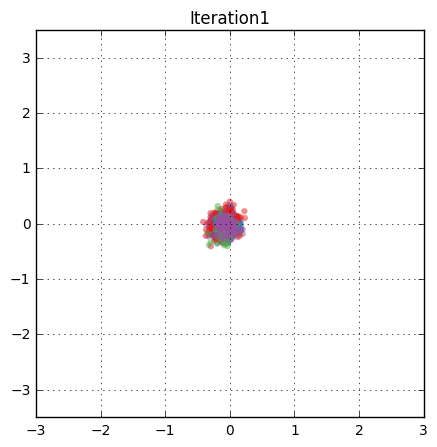

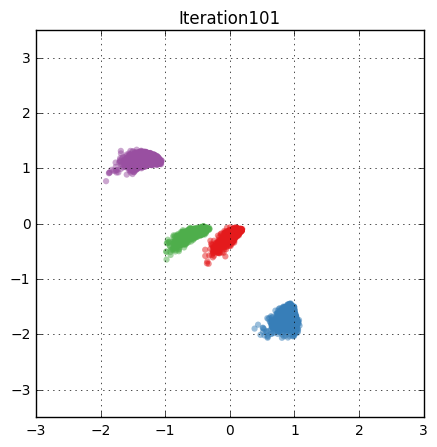

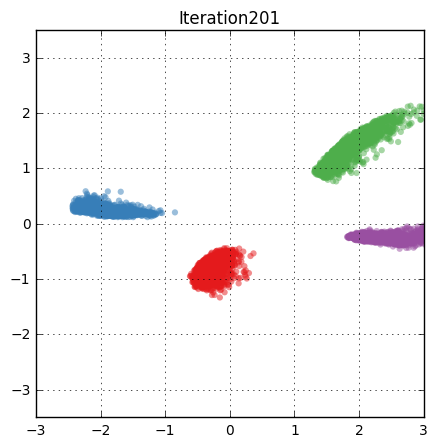

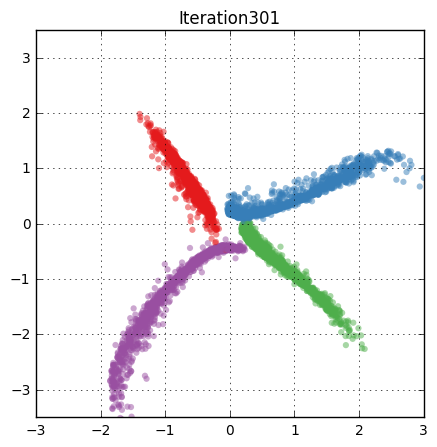

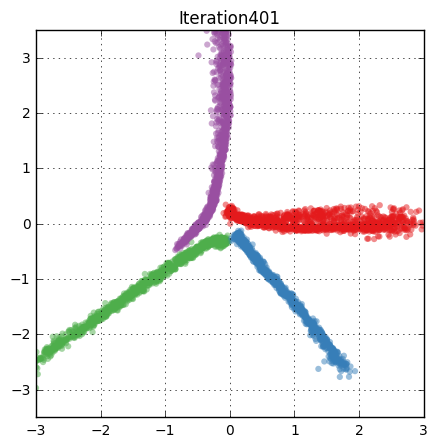

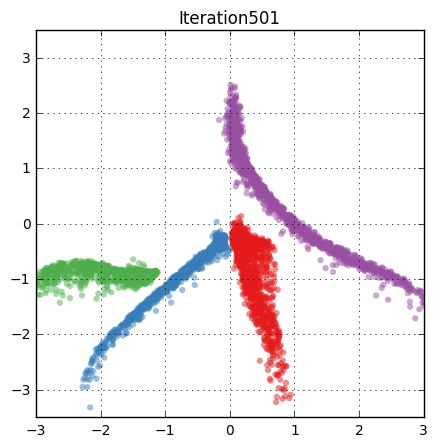

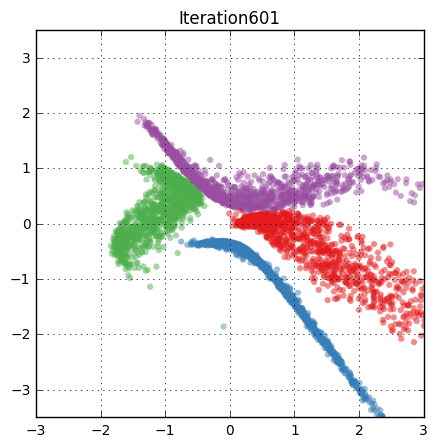

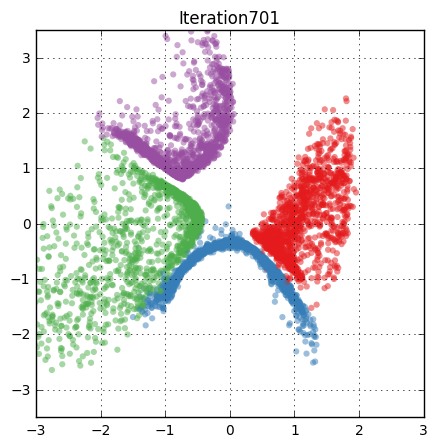

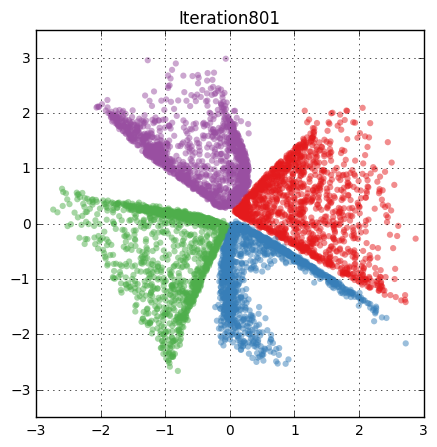

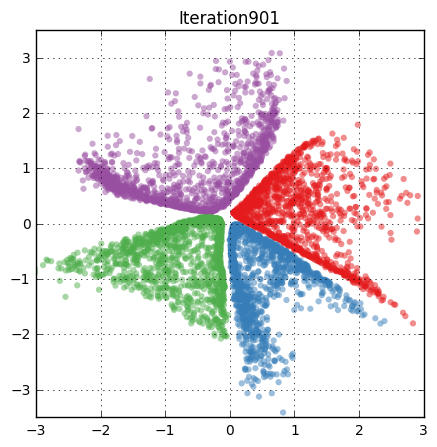

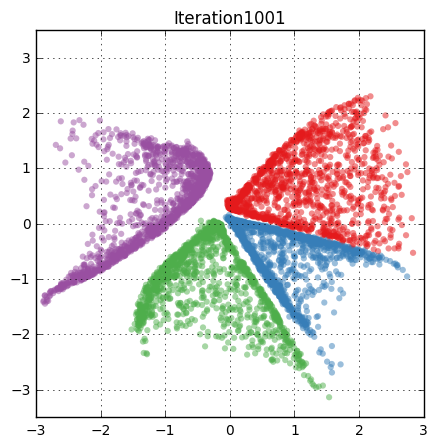

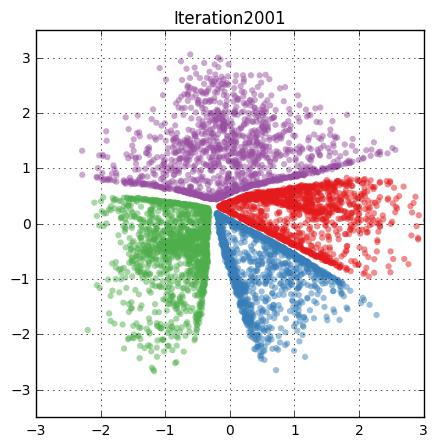

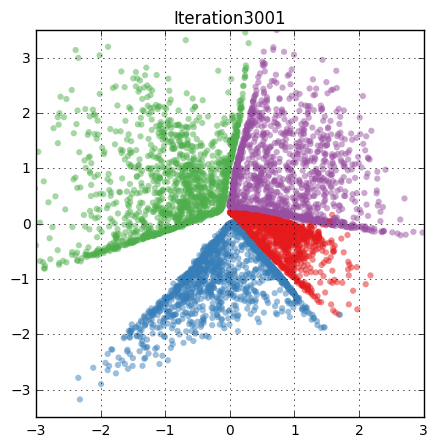

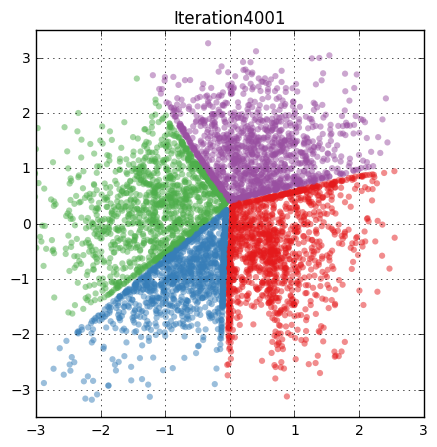

OPTIMIZATION FINISHED.


In [11]:
print ("START OPTIMIZATION.")
# FIX SEEDS
np.random.seed(0) 
tf.set_random_seed(0)
# INITIALIZE 
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fs = []
# RUN
for i in xrange(5000):
    f, _, _ = sess.run([[gen_loss, disc_loss], train_gen_op, train_disc_op])
    fs.append(f)
    if i < 1000: plotevery = 100
    else: plotevery = 1000
    if (i % plotevery) is 0:
        plot_res(niter=i+1)
print ("OPTIMIZATION FINISHED.")

## PLOT LOSSES

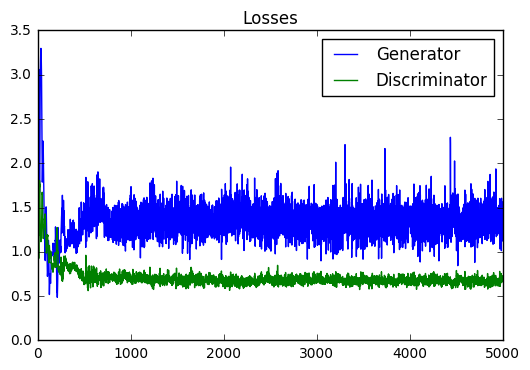

In [12]:
plt.plot(fs)
plt.legend(['Generator', 'Discriminator'])
plt.title('Losses')

## PLOT

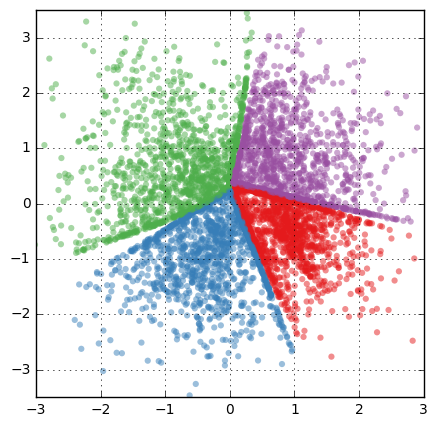

In [13]:
plt.figure(figsize=(5,5), facecolor='w')
n_viz = 10
xx = np.vstack([sess.run(q_z) for _ in range(n_viz)])
ll = np.tile(labels, (n_viz))
plt.scatter(xx[:, 0], xx[:, 1], c=plt.cm.Set1(ll.astype(float)/cfg['input_dim']/2.0),
        edgecolor='none', alpha=0.5)
plt.xlim(-3, 3)
plt.ylim(-3.5, 3.5)
plt.grid('on')